In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import pickle
import dlib

In [2]:
def load_image_to_vector(image_path,image_number):
    img_data=[]
    for i in range (image_number):
        img_color= mpimg.imread(image_path + str(i) + '.jpg')
        img=cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
        width=np.shape(img_color)[0]
        height=np.shape(img_color)[1]
        img_vector=img.reshape(width*height)
        img_data.append(img_vector)
    return img_data

In [3]:
def get_label(label_path,label_name):
    label=pd.read_table(label_path)
    y=label[label_name]
    return y

In [4]:
def SVM_model(x_train,y_train,x_test,y_test):
    clf=SVC(gamma='auto')
    clf.fit(x_train,y_train)
    y_pred =  clf.predict(x_test)
    print('Accuracy on train set:'+str(clf.score(x_train,y_train)))
    print('Accuracy on test set: '+str(accuracy_score(y_test,y_pred)))
    print(classification_report(y_test,y_pred))
    return clf

In [5]:
def img_data_pca(img_data,dimention):
    pca = PCA(n_components = 100)
    pca.fit(img_data)
    pca_data=pca.transform(img_data)
    return pca_data

In [6]:
def lip_feature(img_path,img_number):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
    lip_data=[]
    nothing_number=[]
    for i in range (img_number):
        img = cv2.imread('../datasets/'+img_path+'/img/'+str(i)+'.jpg')
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        positions_68_arr = []
        faces = detector(img_gray, 0)
        if len(faces) !=0:
            landmarks = np.matrix([[p.x, p.y] for p in predictor(img, faces[0]).parts()])
            for idx, point in enumerate(landmarks):
                #coordinates of 68 points
                pos = (point[0, 0], point[0, 1])
                positions_68_arr.append(pos)
            positions_lip_arr = []
            for i in range(48, 68):
                positions_lip_arr.append(positions_68_arr[i][0])
                positions_lip_arr.append(positions_68_arr[i][1])
            lip_data.append(positions_lip_arr)
        else:
            nothing_number.append(i)
            continue
    return lip_data,nothing_number

In [7]:
def lip_feature_read(csv_name):
    img_data = pd.read_csv('./'+csv_name+'.csv')
    img_data=np.array(img_data)
    img_data=img_data[:,1:]
    return img_data

In [8]:
def learn_curve(x_train,y_train,x_test,y_test):
    l2_iter = []
    l2_iter_t = []
    iters = np.arange(5000,10000,500)
    for i in iters:
        lr2 = SVC(gamma='auto',max_iter=i)
        lr2 = lr2.fit(x_train,y_train)
        l2_iter.append(accuracy_score(lr2.predict(x_train),y_train))
        l2_iter_t.append(accuracy_score(lr2.predict(x_test),y_test))
    plt.plot(figsize=(20,6))
    plt.plot(iters,l2_iter,label='accuracy')
    plt.plot(iters,l2_iter_t,label='val_accuracy')
    plt.xticks(iters)
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig("./A2_SVM.jpg") 

In [9]:
%%time
#Data without dimensionality reduction and feature extraction
#get image data
img_data=load_image_to_vector('../datasets/celeba/img/',5000)
#get label
label=get_label('../datasets/celeba/labels.csv','smiling')
#Standardize the data
x_train, x_test, y_train, y_test = train_test_split(img_data, label,test_size=0.1,random_state=0)
transfer=StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)
#train the model and report accuracy
model=SVM_model(x_train,y_train,x_test,y_test)
#save model
pickle.dump(model,open("SVM_smiling.dat","wb")) 

Accuracy on train set:0.9548888888888889
Accuracy on test set: 0.864
              precision    recall  f1-score   support

          -1       0.85      0.89      0.87       261
           1       0.88      0.83      0.85       239

    accuracy                           0.86       500
   macro avg       0.87      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500

CPU times: total: 1h 2min 14s
Wall time: 24min 23s


In [10]:
%%time
#Data with dimensionality reduction by PCA
#get image data
img_data=load_image_to_vector('../datasets/celeba/img/',5000)
#get label
label=get_label('../datasets/celeba/labels.csv','smiling')
#pca for image data
x_train, x_test, y_train, y_test = train_test_split(img_data, label,test_size=0.1,random_state=0)
x_train=img_data_pca(x_train,100)
x_test=img_data_pca(x_test,100)
#Standardize the data
transfer=StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)
#train the model and report accuracy
model=SVM_model(x_train,y_train,x_test,y_test)
#save model
pickle.dump(model,open("SVM_smiling_PCA.dat","wb")) 

Accuracy on train set:0.9493333333333334
Accuracy on test set: 0.428
              precision    recall  f1-score   support

          -1       0.45      0.45      0.45       261
           1       0.40      0.41      0.40       239

    accuracy                           0.43       500
   macro avg       0.43      0.43      0.43       500
weighted avg       0.43      0.43      0.43       500

CPU times: total: 37.3 s
Wall time: 9.74 s


In [11]:
%%time
#Data with feature extraction
img_data,nothing_number=lip_feature('celeba',5000)
#get label
label=get_label('../datasets/celeba/labels.csv','smiling')
for i in range(len(nothing_number)):
    del label[nothing_number[i]]
#Standardize the data
x_train, x_test, y_train, y_test = train_test_split(img_data, label,test_size=0.1,random_state=0)
transfer=StandardScaler()
x_train = transfer.fit_transform(x_train)
x_test = transfer.transform(x_test)
#train the model and report accuracy
model=SVM_model(x_train,y_train,x_test,y_test)
#save model
pickle.dump(model,open("SVM_smiling_dlib_lip.dat","wb")) 

Accuracy on train set:0.8961961503208066
Accuracy on test set: 0.8907216494845361
              precision    recall  f1-score   support

          -1       0.88      0.91      0.89       241
           1       0.91      0.87      0.89       244

    accuracy                           0.89       485
   macro avg       0.89      0.89      0.89       485
weighted avg       0.89      0.89      0.89       485

CPU times: total: 27.3 s
Wall time: 27.8 s


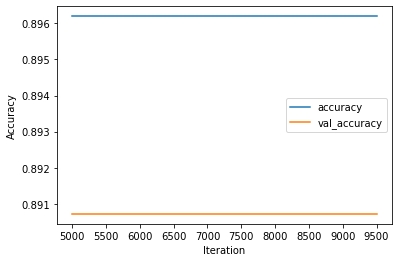

<Figure size 432x288 with 0 Axes>

In [29]:
#learning_curve for SVM
learn_curve(x_train,y_train,x_test,y_test)

In [ ]:
#The following is for testing 

In [12]:
%%time
##Data without dimensionality reduction and feature extraction
#get and preprocess image data for testing
img_data_test=load_image_to_vector('../datasets/celeba_test/img/',1000)
img_data_test = transfer.fit_transform(img_data_test)
#get label_test
label_test=get_label('../datasets/celeba_test/labels.csv','smiling')
#load model
loaded_model = pickle.load(open("SVM_smiling.dat","rb"))
label_pred=loaded_model.predict(img_data_test)
print('Accuracy on test set: '+str(accuracy_score(label_test,label_pred)))
print(classification_report(label_test,label_pred))

Accuracy on test set: 0.879
              precision    recall  f1-score   support

          -1       0.86      0.90      0.88       500
           1       0.90      0.86      0.88       500

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000

CPU times: total: 6min 14s
Wall time: 2min 16s


In [13]:
%%time
#Data with dimensionality reduction by PCA
#get and preprocess image data for testing
img_data_test=load_image_to_vector('../datasets/celeba_test/img/',1000)
img_data_test = transfer.fit_transform(img_data_test )
#get label
label_test=get_label('../datasets/celeba_test/labels.csv','smiling')
#pca for image data
img_data_test=img_data_pca(img_data_test,100)
#load model
loaded_model = pickle.load(open("SVM_smiling_PCA.dat","rb"))
label_pred=loaded_model.predict(img_data_test)
print('Accuracy on test set: '+str(accuracy_score(label_test,label_pred)))
#print(classification_report(label_test,label_pred))

Accuracy on test set: 0.5
CPU times: total: 5.11 s
Wall time: 1.96 s


In [14]:
%%time
#Data with feature extraction
#get and preprocess image data for testing
img_data_test,nothing_number_test=lip_feature('celeba_test',1000)
img_data_test = transfer.fit_transform(img_data_test )
#get label
label_test=get_label('../datasets/celeba_test/labels.csv','smiling')
for i in range(len(nothing_number_test)):
    del label_test[nothing_number_test[i]]
#load model
loaded_model = pickle.load(open("SVM_smiling_dlib_lip.dat","rb"))
label_pred=loaded_model.predict(img_data_test)
print('Accuracy on test set: '+str(accuracy_score(label_test,label_pred)))
print(classification_report(label_test,label_pred))

Accuracy on test set: 0.8944672131147541
              precision    recall  f1-score   support

          -1       0.87      0.92      0.90       477
           1       0.92      0.87      0.89       499

    accuracy                           0.89       976
   macro avg       0.90      0.90      0.89       976
weighted avg       0.90      0.89      0.89       976

CPU times: total: 5.94 s
Wall time: 5.94 s
